# $f(K)$ metrikos naudojimo pavyzdys K-vidurkių klasterizavimo rezultatams

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import Image
import plotnine as gg
import pandas as pd

`pyspark.ml.clustering.KMeansModel` metodas `computeCost` apskaičiuoja stebėjimų Euklido atstumų nuo savo klasterių  centrų sumą $S_K$ (angl. _Within Set Sum of Squared Error (WSSSE)_):

$I_k = \sum_{\mathbf{x}_i \in C_k} \| \mathbf{x}_i - \mathbf{\overline{x}}_k \|$

$S_K = \sum_{k}^{K} I_k$

čia 

$k$ - klasterio indeksas,

$C_k$ - $k$-asis klasteris

$K$ - klasterių skaičius,

$N_k$ - $k$-jam klasteriui priklausančių stebėjimų skaičius,

$\mathbf{x_i}$ - $i$-tojo stebėjimo vektorius,

$\mathbf{\overline{x}}_k$ - $k$-otojo klasterio vidurinio taško (centro) vektorius,

$\|\mathbf{x}\|$ - vektoriaus Euklido norma, t.y. kvadratinė šaknis iš jo komponenčių kvadratų sumos.

$f(K)$ yra naudojama nustatyti optimalią $K$ reikšmę ir yra aprašyta [čia](http://www.ee.columbia.edu/~dpwe/papers/PhamDN05-kmeans.pdf) ir [čia](https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/). Jos reikšmė $f(K)$ apskaičiuojama tokiu būdu:

In [24]:
Image("../data/img/fk.png")

FileNotFoundError: No such file or directory: '../data/img/fk.png'

FileNotFoundError: No such file or directory: '../data/img/fk.png'

<IPython.core.display.Image object>

Optimilaus $K$ yra ties mažiausia $f(K)$ reikšme.

Realizuojame formulės išraišką.

In [4]:
def compute_fk(k, sse, prev_sse, dim):
    if k == 1 or prev_sse == 0:
        return 1
    weight = weight_factor(k, dim)
    return sse / (weight * prev_sse)

# calculating alpha_k in functional style with tail recursion -- which is not optimized in Python :(
def weight_factor(k, dim):
    if not k > 1:
        raise ValueError("k must be greater than 1")
        
    def weigth_factor_accumulator(acc, k):
        if k == 2:
            return acc
        return weigth_factor_accumulator(acc + (1 - acc) / 6, k - 1)
        
    weight_k2 = 1 - 3 / (4 * dim)
    return weigth_factor_accumulator(weight_k2, k)

Aprašome funkciją, kuri iš $K$ ir $S_K$ reikšmių porų `list`'o pateikia galimas įvertinti $f(K)$ reikšmes.

In [5]:
def compute_fk_from_k_sse_pairs(k_sse_pairs, dimension):
    triples = make_fk_triples(k_sse_pairs)
    k_fk_pairs = [
        (k, compute_fk(k, sse, prev_sse, dimension))
        for (k, sse, prev_sse) in triples]
    return sorted(k_fk_pairs, key=lambda pair: pair[0])


def make_fk_triples(k_sse_pairs):
    sorted_pairs = sorted(k_sse_pairs, reverse=True)
    candidates = list(zip(sorted_pairs, sorted_pairs[1:] + [(0, 0.0)]))
    triples = [
        (k, sse, prev_sse)
        for ((k, sse), (prev_k, prev_sse)) in candidates
        if k - prev_k == 1
    ]
    return triples

Naudojimo pavyzdys:

In [8]:
! cat ../data/output/k_means/metrics_kmeans_see.jsonl

{"k": 2, "sse": 707494.9515918358}
{"k": 3, "sse": 618441.4322651019}
{"k": 4, "sse": 575597.6014390701}
{"k": 5, "sse": 532671.7891047668}
{"k": 6, "sse": 487044.7995164254}
{"k": 7, "sse": 439988.06058513746}
{"k": 8, "sse": 427941.09643131203}
{"k": 9, "sse": 410221.9842424506}
{"k": 10, "sse": 398538.27553586423}


Tarkime, iš disko nuskaitome tokią $K$ ir $S_K$ reikšmių lentelę.

In [9]:
metrics_pddf = pd.read_json(
    "../data/output/k_means/metrics_kmeans_see.jsonl", 
    orient="records",
    lines=True)

metrics_pddf

,k,sse
0,2,707494.951592
1,3,618441.432265
2,4,575597.601439
3,5,532671.789105
4,6,487044.799516
5,7,439988.060585
6,8,427941.096431
7,9,410221.984242
8,10,398538.275536


Pakeičiame stulpelių tvarką.

In [10]:
k_sse_pddf = metrics_pddf[["k", "sse"]]

k_sse_pddf

,k,sse
0,2,707494.951592
1,3,618441.432265
2,4,575597.601439
3,5,532671.789105
4,6,487044.799516
5,7,439988.060585
6,8,427941.096431
7,9,410221.984242
8,10,398538.275536


Skačiuojant $f(K)$ metriką reikia žinoti duomenų dimensiją, t.y. klasterizavimui naudotų požymių skaičių. Tarkime, kad šiuo atveju naudojome du požymius.

In [19]:
dimension = 21 

k_sse_pairs = [tuple(r) for r in k_sse_pddf.to_records(index=False)]
k_sse_pairs

[(2, 707494.9515918358),
 (3, 618441.4322651019),
 (4, 575597.6014390701),
 (5, 532671.7891047668),
 (6, 487044.7995164254),
 (7, 439988.06058513746),
 (8, 427941.09643131203),
 (9, 410221.9842424506),
 (10, 398538.27553586423)]

In [20]:
k_fk_pairs = compute_fk_from_k_sse_pairs(k_sse_pairs, dimension)
k_fk_pairs

[(3, 0.900942157838302),
 (4, 0.9543933673831541),
 (5, 0.944954224677812),
 (6, 0.9303671616959016),
 (7, 0.916538000074054),
 (8, 0.9843937746001337),
 (9, 0.9682452019386667),
 (10, 0.9796555907678971)]

In [21]:
k_fk_pddf = pd.DataFrame.from_records(k_fk_pairs, columns=["k", "fk"])
k_fk_pddf

,k,fk
0,3,0.900942
1,4,0.954393
2,5,0.944954
3,6,0.930367
4,7,0.916538
5,8,0.984394
6,9,0.968245
7,10,0.979656


In [22]:
plot_k_sse = (
    gg.ggplot(gg.aes(x="k", y="sse"), data=k_sse_pddf) + 
    gg.geom_line() + 
    gg.xlab("K") +
    gg.ylab("SSE") + 
    gg.ggtitle("SSE pagal klasterių skaičių K") +
    gg.theme_bw()
)

plot_k_fk = (
    gg.ggplot(gg.aes(x="k", y="fk"), data=k_fk_pddf) + 
    gg.geom_line() + 
    gg.xlab("K") +
    gg.ylab("f(K)") + 
    gg.ggtitle("f(K) pagal klasterių skaičių K") +
    gg.theme_bw()
)

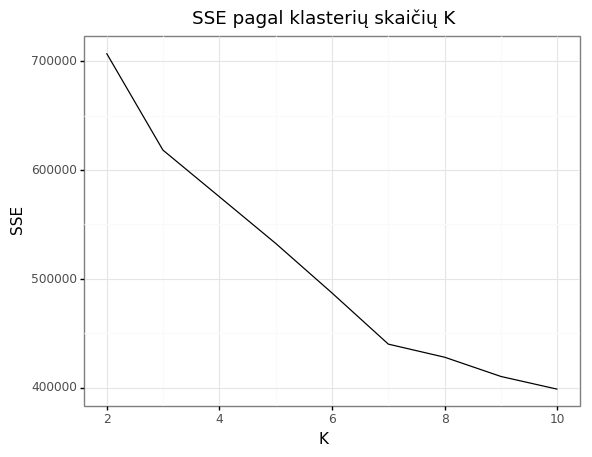

<ggplot: (8728422484733)>


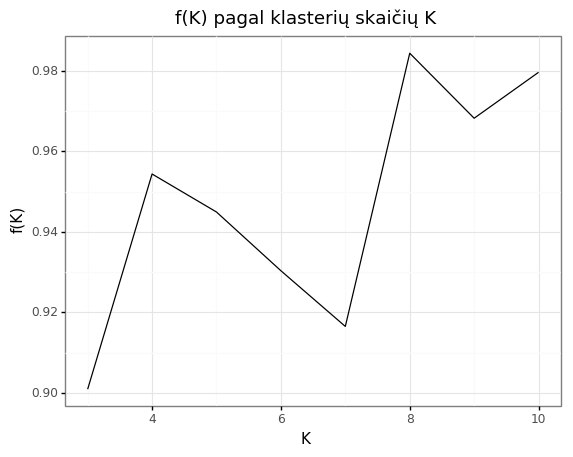

<ggplot: (8728422388172)>


In [23]:
print(plot_k_sse)
print(plot_k_fk)

Galime išsaugoti grafikus naudodami grafiko objekto `save` metodą.

In [15]:
help(plot_k_fk.save)

NameError: name 'plot_k_fk' is not defined

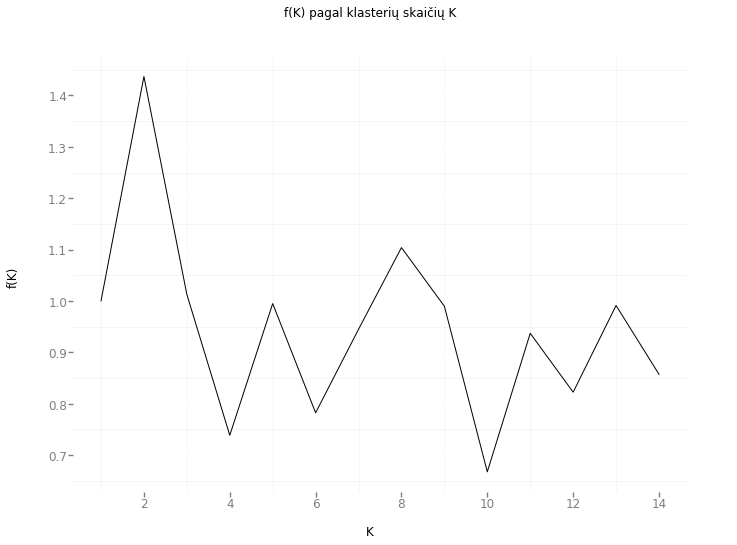

In [15]:
plot_k_sse.save("../data/img/k_sse.png")
plot_k_fk.save("../data/img/k_fk.png")

**Pastaba**: visuomet reikėtų išsaugoti ir duomenis, kuriuos naudojame grafikų braižymui (šiuo atveju metrikas). Turint šiuos duomenis, grafikus galėsime perbražyti bet kada. Nenorėtume atsidurti situacijoje, kai turime iš naudo atlikti modeliavimą tam, kad pakeisti grafiko stilių.

Taip pat, išsaugant grafikų duomenis `csv` formatu, grafiką galima braižyti naudojant *R* ar kitas priemones, nebūtinai Python.

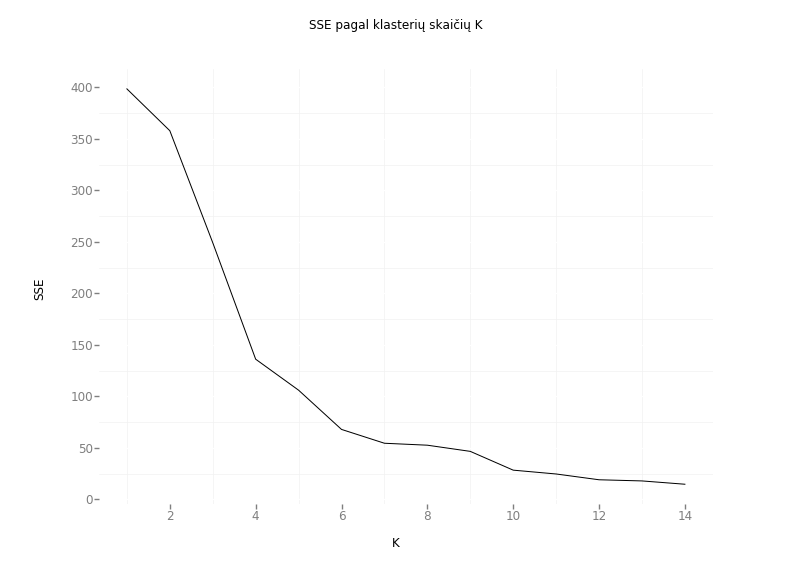

In [16]:
Image("../data/img/k_sse.png")

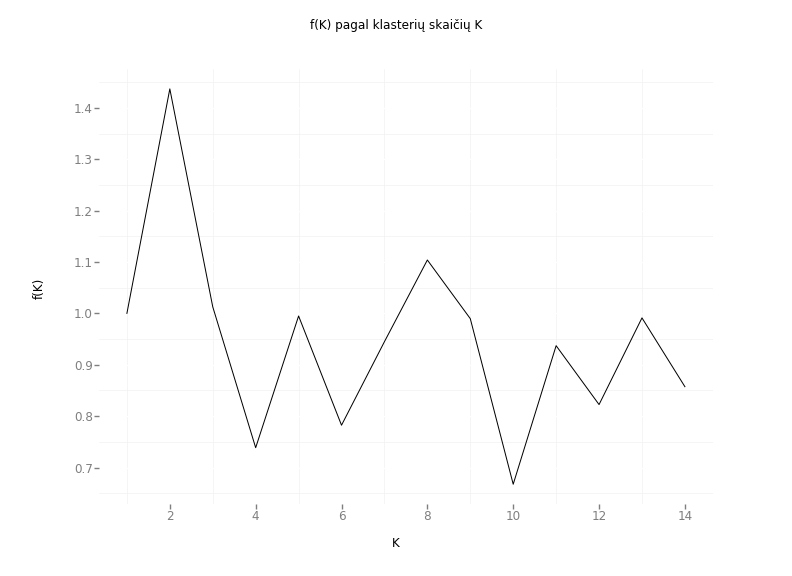

In [17]:
Image("../data/img/k_fk.png")

Pandas DataFrame saugojimas `csv` formatu:

In [18]:
k_fk_pddf.to_csv("../data/examples_io/metrics__k_means__fk.csv", index=False)

In [19]:
! cat ../data/examples_io/metrics__k_means__fk.csv

k,fk
1,1.0
2,1.4369758053185464
3,1.0127898848274375
4,0.7385292831618783
5,0.9949326364843412
6,0.7823399555197494
7,0.9449162996009715
8,1.1039089924248602
9,0.9897485666925573
10,0.6674323449746364
11,0.9371098484061138
12,0.8224915353199767
13,0.9912144776818466
14,0.8572897702088025


Žemiau pateikiame sklaidos diagramą duomenų, kurių klasterizavimo rezultatų metrikas naudojome šiame pavyzdyje.

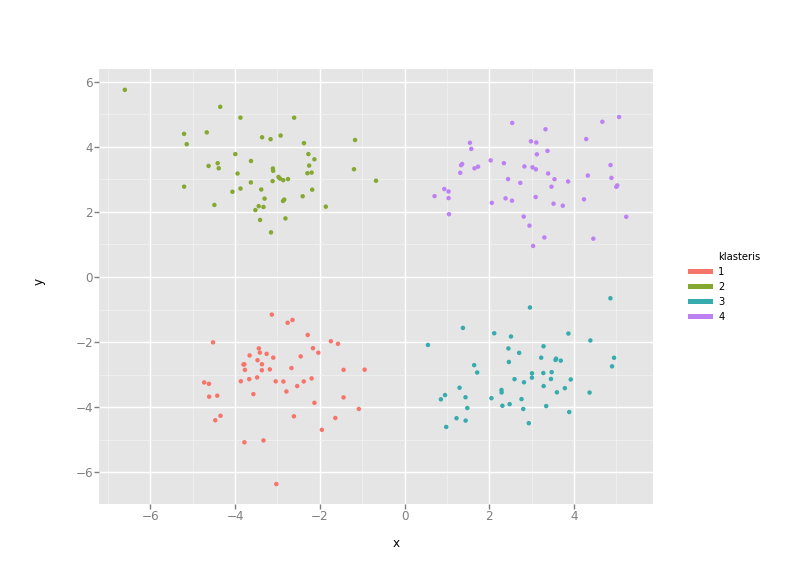

In [20]:
Image("../data/img/scatter_clusters_4.png")

**Užduotys**:
1. Parašyti Python funkciją `compute_fk_from_pddf(k_sse_pddf)`, kuri priimtų `pandas.DataFrame` su $k$ ir $sse$ stulpelias ir gražintų `pandas.DataFrame` su $k$ stulpeliu ir apskaičiuotos $f(K)$ metrikos stulpeliu.
1. Parašyti Python funkciją `compute_fk_from_to_jsonl(path_input, path_output)`, kuri priimtų kelią į _json lines_ formato failą, kuriame saugomos $k$ ir $sse$ metrikos reikšmės, kelią į išvesties failą. Funkcija apskaičiuotų $f(K)$ metrikos reikšmes ir jas išsaugotų  jas kartu su $k$ reikšmėmis _json lines_ formatu į išvesties failą. _Labai patariame panaudoti (1) užduotyje aprašytą funkciją_.